# Dependencies

In [1]:
pacman::p_load(dplyr, ggplot2, pBrackets, ggpubr)

# Functions

In [2]:
source("/Users/anabbi/git/ped_CapTCRseq/R/ggplot2_theme.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/color_schemes.R")

# Paths

In [3]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Plots/"
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Manifests/"
gitpath <- "/Users/anabbi/git/ped_CapTCRseq/"

In [4]:
h4hpath <- "/Users/anabbi/Desktop/H4H/INTERCEPT/"

# Main

bind all metadata

In [5]:
meta_div <- readr::read_rds(file = paste0(datapath,"capTCRseq/meta_div_goodsamples.rds"))

In [6]:
subset_meta <- meta_div[, c("Patient", "cycle", "FOLD", "Disease_type", 
"CD3", "cancergroup", "sampletype", "TRB", "Age")]

In [7]:
meta_div[ meta_div$Patient == "CHP_437", ]

,sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,Pass,CD3,...,observed_Shannon,estimated_Shannon,SE_Shannon,observed_Simpson,estimated_Simpson,SE_Simpson,file,basename,Group,sampletype
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<lgl>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
829,CHP_437_01,CHP_437,X01,0,0,9,OS,0,NA,0,...,NA,NA,NA,NA,NA,NA,NA,NA,CHP,PBMC
830,CHP_437_02,CHP_437,X02,0,0,9,OS,0,NA,0,...,NA,NA,NA,NA,NA,NA,NA,NA,CHP,PBMC
831,CHP_437_03,CHP_437,X03,0,0,9,OS,0,NA,0,...,NA,NA,NA,NA,NA,NA,NA,NA,CHP,PBMC
832,CHP_437_04,CHP_437,X04,0,0,9,OS,0,NA,0,...,NA,NA,NA,NA,NA,NA,NA,NA,CHP,PBMC
833,CHP_437_05,CHP_437,X05,0,0,9,OS,0,NA,0,...,NA,NA,NA,NA,NA,NA,NA,NA,CHP,PBMC


In [8]:
# recode cycle to numeric
subset_meta$cycle <- gsub("X", "", subset_meta$cycle)

In [9]:
subset_meta$cycle <- as.numeric(subset_meta$cycle)

In [10]:
table(subset_meta$sampletype, useNA = "ifany")


 PBMC Tumor cfDNA 
  430    18   267 

In [11]:
# NAs are flow
subset_meta$sampletype[ is.na(subset_meta$sampletype) ] <- "Flow"

In [12]:
#remove Tumor samples
subset_meta <- subset_meta[ which(subset_meta$sampletype != "Tumor"),]
#remove Normal samples
subset_meta <- subset_meta[ which(subset_meta$cancergroup != "Normal"),]
# remove LFS samples
subset_meta <- subset_meta[which(subset_meta$cancergroup != "LFS"),]

In [13]:
table(subset_meta$sampletype, useNA = "ifany")


 PBMC cfDNA 
  406   267 

In [14]:
length(table(subset_meta$Patient))

[1] 108

In [15]:
mydat <- matrix(ncol = 20, nrow = length(unique(subset_meta$Patient)))
rownames(mydat) <- unique(subset_meta$Patient)
# assign colnames 5 PBMCs, 5 cfDNA, 5 FOLD,  5 CD3 separate by _
colnames(mydat) <- c(paste0(rep("PBMC_", 5), 1:5),
                        paste0(rep("cfDNA_", 5), 1:5),
                        paste0(rep("FOLD_", 5), 1:5),
                        paste0(rep("CD3_", 5), 1:5))

In [16]:
datatype.fx <- function(x){

x$datatype <- NA
for(i in 1:nrow(x)){
#if is.na(TRB) & !is.na(FOLD) & !is.na(CD3), then datatype = FOLD,CD3
    if(is.na(x$TRB[i]) & !is.na(x$FOLD[i]) & !is.na(x$CD3[i])){
        x$datatype[i] <- paste0("FOLD", "_",x$cycle[i], ",", "CD3","_", x$cycle[i])
    }
#if is.na(TRB) & !is.na(CD3) & is.na(FOLD), then datatype = CD3
    if(is.na(x$TRB[i]) & !is.na(x$CD3[i]) & is.na(x$FOLD[i])){
        x$datatype[i] <- paste0("CD3","_", x$cycle[i])
    }
#if is.na(TRB) & is.na(CD3) & !is.na(FOLD), then datatype = FOLD
    if(is.na(x$TRB[i]) & !is.na(x$FOLD[i]) & is.na(x$CD3[i])){
        x$datatype[i] <- paste0("FOLD","_", x$cycle[i])
    }
#if !is.na(TRB) & !is.na(CD3) & is.na(FOLD) & sampletype == "PBMC", then datatype = PBMC, CD3
    if(!is.na(x$TRB[i]) & !is.na(x$CD3[i]) & is.na(x$FOLD[i]) & x$sampletype[i] == "PBMC"){
        x$datatype[i] <- paste0("PBMC","_", x$cycle[i], ",", "CD3","_", x$cycle[i])
    }

#if !is.na(TRB) & is.na(CD3) & !is.na(FOLD) & sampletype == "PBMC", then datatype = PBMC, FOLD
    if(!is.na(x$TRB[i]) & is.na(x$CD3[i]) & !is.na(x$FOLD[i]) & x$sampletype[i] == "PBMC"){
        x$datatype[i] <- paste0("PBMC","_", x$cycle[i], ",", "FOLD","_", x$cycle[i])
    }

#if !is.na(TRB) & & !is.na(CD3) & !is.na(FOLD) & sampletype == "PBMC", then datatype = PBMC, FOLD, CD3
    if(!is.na(x$TRB[i]) & !is.na(x$CD3[i]) & !is.na(x$FOLD[i]) & x$sampletype[i] == "PBMC"){
        x$datatype[i] <- paste0("PBMC","_", x$cycle[i], ",", "FOLD","_", x$cycle[i], ",", "CD3","_", x$cycle[i])
    }
#if sampletype == "cfDNA", then datatype = cfDNA
    if(x$sampletype[i] == "cfDNA"){
        x$datatype[i] <- paste0("cfDNA","_", x$cycle[i])
    }
}

# separate_rows based on , in datatype_cycle
x_s <- x %>% tidyr::separate_rows(datatype, sep = ",")

pw <- tidyr::pivot_wider(x_s[, c("Patient", "datatype", "Age")], 
names_from = datatype, values_from = Age)

pw <- as.data.frame(pw)
rownames(pw) <- pw$Patient
pw$Patient <- NULL

# match colnames(pw) with colnames(mydat), pw$Patient with rownames(mydat)
mydat[ rownames(pw), colnames(pw)] <- as.matrix(pw) 
#print(pw)
return(mydat)
}

In [17]:
table(subset_meta$cancergroup, useNA = "ifany")


Leukemia Lymphoma    Solid 
     323      126      224 

In [18]:
head(meta_div[,34:58],10)

,PD1...LAG3...TIM3,cancergroup,TRB,Reads,CPKR,Average_reads,VMR,Max_reads,Singletons,Doubletons,...,observed_Shannon,estimated_Shannon,SE_Shannon,observed_Simpson,estimated_Simpson,SE_Simpson,file,basename,Group,sampletype
,<dbl>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,NA,Normal,19,12722,1.4934759,669.57895,1.1351437,3012,4,0,...,10.591,10.601,0.074,8.556,8.561,0.097,batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_10YO-M_PBMC_DNA.txt,CHP_10YO-M_PBMC_DNA,CHP,PBMC
2,NA,Normal,16,13419,1.1923392,838.68750,0.7572099,1927,2,0,...,11.607,11.614,0.055,10.406,10.414,0.074,batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_11YO-M_PBMC_DNA.txt,CHP_11YO-M_PBMC_DNA,CHP,PBMC
3,NA,Normal,11,6601,1.6664142,600.09091,0.5598956,1124,0,0,...,8.982,8.989,0.042,8.560,8.570,0.060,batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_15YO-F-A_PBMC_DNA.txt,CHP_15YO-F-A_PBMC_DNA,CHP,PBMC
4,NA,Normal,7,4584,1.5270506,654.85714,0.4739194,992,0,0,...,6.330,6.334,0.039,5.870,5.876,0.059,batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_15YO-F-B_PBMC_DNA.txt,CHP_15YO-F-B_PBMC_DNA,CHP,PBMC
5,NA,Normal,23,22076,1.0418554,959.82609,0.3712367,1673,0,0,...,21.110,21.120,0.040,20.321,20.339,0.079,batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_15YO-M_PBMC_DNA.txt,CHP_15YO-M_PBMC_DNA,CHP,PBMC
6,NA,Normal,4,4731,0.8454872,1182.75000,0.1378384,1354,0,0,...,3.972,3.973,0.007,3.944,3.946,0.012,batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_16YO-M_PBMC_DNA.txt,CHP_16YO-M_PBMC_DNA,CHP,PBMC
7,NA,Normal,50,41199,1.2136217,823.98000,1.0021649,4561,2,0,...,34.170,34.191,0.131,25.198,25.213,0.217,batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_1YO-M-A_PBMC_DNA.txt,CHP_1YO-M-A_PBMC_DNA,CHP,PBMC
8,NA,Normal,3,2206,1.3599275,735.33333,0.8704772,1188,0,0,...,2.013,2.014,0.010,1.993,1.994,0.006,batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_1YO-M-B_PBMC_DNA.txt,CHP_1YO-M-B_PBMC_DNA,CHP,PBMC
9,NA,Normal,10,5868,1.7041581,586.80000,0.6499525,1057,0,0,...,7.910,7.916,0.053,7.245,7.253,0.059,batchNormal_16Apr2020/mixcr/clones/CLONES_TRBCHP_2YO-M_PBMC_DNA.txt,CHP_2YO-M_PBMC_DNA,CHP,PBMC


In [19]:
dim(meta_div)

[1] 715  58

In [20]:
for(p in unique(subset_meta$Patient)){
    x <- subset_meta[subset_meta$Patient == p, ]
    mydat <- datatype.fx(x)
}

In [21]:
mydat_m <- reshape2::melt(mydat, na.rm = TRUE)

In [22]:
mydat_m$cycle <- gsub(".*_", "", mydat_m$Var2)
mydat_m$Datatype <- gsub("_.*", "", mydat_m$Var2)

In [23]:
mydat_m$cycle <- as.factor(mydat_m$cycle)

In [24]:
mydat_m$cancergroup <- subset_meta$cancergroup[match(mydat_m$Var1, subset_meta$Patient)]

In [25]:
table(mydat_m$Datatype, useNA = "ifany")


  CD3  FOLD  PBMC cfDNA 
  405   403   191   267 

In [26]:
head(mydat_m)

,Var1,Var2,value,cycle,Datatype,cancergroup
,<fct>,<fct>,<dbl>,<fct>,<chr>,<chr>
11,CHP_346,PBMC_1,1,1,PBMC,Solid
12,CHP_347,PBMC_1,13,1,PBMC,Leukemia
13,CHP_348,PBMC_1,18,1,PBMC,Solid
14,CHP_349,PBMC_1,17,1,PBMC,Leukemia
15,CHP_350,PBMC_1,1,1,PBMC,Solid
17,CHP_352,PBMC_1,17,1,PBMC,Leukemia


In [27]:
patients_cycles <- cbind.data.frame( unique(mydat_m$Var1), "5")
colnames(patients_cycles) <- c("Patient", "cycle")
patients_cycles$Patient <- as.character(patients_cycles$Patient)

patients_cycles$cancergroup <- subset_meta$cancergroup[match(patients_cycles$Patient, subset_meta$Patient)]
patients_cycles$Disease_type <- subset_meta$Disease_type[match(patients_cycles$Patient, subset_meta$Patient)]
patients_cycles$Age <- subset_meta$Age[match(patients_cycles$Patient, subset_meta$Patient)]

In [28]:
head(patients_cycles)

,Patient,cycle,cancergroup,Disease_type,Age
,<chr>,<chr>,<chr>,<chr>,<dbl>
1,CHP_346,5,Solid,NB,1
2,CHP_347,5,Leukemia,ALL,13
3,CHP_348,5,Solid,OS,18
4,CHP_349,5,Leukemia,CML,17
5,CHP_350,5,Solid,HB,1
6,CHP_352,5,Leukemia,HR ALL,17


In [29]:
patients_cycles$Patient <- factor(patients_cycles$Patient, levels = patients_cycles$Patient[order(patients_cycles$cancergroup, 
patients_cycles$Disease_type, patients_cycles$Age)])

In [30]:
mydat_m$Var1 <- factor(mydat_m$Var1, levels = levels(patients_cycles$Patient))

In [31]:
patients_cycles$cycle <- as.numeric(patients_cycles$cycle)

In [32]:
mydat_m$cycle <- as.numeric(mydat_m$cycle)

In [33]:
# recode cycle to 6, just for plotting
patients_cycles$cycle <- ifelse(patients_cycles$cycle == 5, 6, patients_cycles$cycle)

In [34]:
levels(patients_cycles$Patient)

[1] "CHP_378" "CHP_410" "CHP_416" "CHP_345" "CHP_339" "CHP_340" "CHP_424"
  [8] "CHP_373" "CHP_397" "CHP_420" "CHP_423" "CHP_428" "CHP_388" "CHP_360"
 [15] "CHP_398" "CHP_365" "CHP_383" "CHP_392" "CHP_421" "CHP_336" "CHP_422"
 [22] "CHP_347" "CHP_417" "CHP_406" "CHP_369" "CHP_357" "CHP_376" "CHP_342"
 [29] "CHP_353" "CHP_354" "CHP_338" "CHP_359" "CHP_413" "CHP_435" "CHP_405"
 [36] "CHP_341" "CHP_349" "CHP_396" "CHP_399" "CHP_355" "CHP_402" "CHP_391"
 [43] "CHP_367" "CHP_411" "CHP_352" "CHP_377" "CHP_382" "CHP_334" "CHP_331"
 [50] "CHP_395" "CHP_387" "CHP_375" "CHP_433" "CHP_370" "CHP_344" "CHP_386"
 [57] "CHP_371" "CHP_372" "CHP_337" "CHP_412" "CHP_407" "CHP_403" "CHP_389"
 [64] "CHP_333" "CHP_434" "CHP_361" "CHP_366" "CHP_380" "CHP_415" "CHP_430"
 [71] "CHP_400" "CHP_368" "CHP_401" "CHP_404" "CHP_332" "CHP_394" "CHP_374"
 [78] "CHP_381" "CHP_343" "CHP_356" "CHP_409" "CHP_363" "CHP_335" "CHP_350"
 [85] "CHP_414" "CHP_384" "CHP_379" "CHP_346" "CHP_418" "CHP_385" "CHP_408"
 [92] "CHP_330" "CHP_390" "CHP_351" "CHP_437" "CHP_393" "CHP_419" "CHP_432"
 [99] "CHP_436" "CHP_362" "CHP_364" "CHP_348" "CHP_431" "CHP_426" "CHP_427"
[106] "CHP_425" "CHP_429" "CHP_358"

In [35]:
head(mydat_m)

,Var1,Var2,value,cycle,Datatype,cancergroup
,<fct>,<fct>,<dbl>,<dbl>,<chr>,<chr>
11,CHP_346,PBMC_1,1,1,PBMC,Solid
12,CHP_347,PBMC_1,13,1,PBMC,Leukemia
13,CHP_348,PBMC_1,18,1,PBMC,Solid
14,CHP_349,PBMC_1,17,1,PBMC,Leukemia
15,CHP_350,PBMC_1,1,1,PBMC,Solid
17,CHP_352,PBMC_1,17,1,PBMC,Leukemia


In [36]:
mydat_m$Var2 <- as.character(mydat_m$Var2)

In [37]:
mydat_m$Datatype[mydat_m$Datatype == "PBMC"] <- "CapTCR-seq(PBMC)"
mydat_m$Datatype[mydat_m$Datatype == "cfDNA"] <- "CapTCR-seq(cfDNA)"
mydat_m$Datatype[mydat_m$Datatype == "FOLD"] <- "ex vivo T-cell expansion"
mydat_m$Datatype[mydat_m$Datatype == "CD3"] <- "Flow cytometry"

In [38]:
mydat_m$newcycle <- NA

for(i in 1:5){
    mydat_m$newcycle[mydat_m$cycle == i & mydat_m$Datatype == "CapTCR-seq(PBMC)"] <- i-0.2
    mydat_m$newcycle[mydat_m$cycle == i & mydat_m$Datatype == "CapTCR-seq(cfDNA)"] <- i-0.1
    mydat_m$newcycle[mydat_m$cycle == i & mydat_m$Datatype == "ex vivo T-cell expansion"] <- i + 0.1
    mydat_m$newcycle[mydat_m$cycle == i & mydat_m$Datatype == "Flow cytometry"] <- i+ 0.2
}

In [39]:
dim(patients_cycles)

[1] 108   5

In [40]:
head(mydat_m)

,Var1,Var2,value,cycle,Datatype,cancergroup,newcycle
,<fct>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
11,CHP_346,PBMC_1,1,1,CapTCR-seq(PBMC),Solid,0.8
12,CHP_347,PBMC_1,13,1,CapTCR-seq(PBMC),Leukemia,0.8
13,CHP_348,PBMC_1,18,1,CapTCR-seq(PBMC),Solid,0.8
14,CHP_349,PBMC_1,17,1,CapTCR-seq(PBMC),Leukemia,0.8
15,CHP_350,PBMC_1,1,1,CapTCR-seq(PBMC),Solid,0.8
17,CHP_352,PBMC_1,17,1,CapTCR-seq(PBMC),Leukemia,0.8


In [41]:
p0 <- ggplot( patients_cycles, aes(Patient, cycle)) +
  geom_bar(stat="identity", aes(fill=cancergroup), width= 0.8, alpha = 0.2) +
  geom_point(data=mydat_m,aes(Var1, newcycle, colour = Datatype, shape=Datatype), size=1.5) +
  coord_flip() +
  scale_fill_manual(values= group_col[c("Leukemia", "Lymphoma", "Solid")]) +
  scale_color_brewer(palette = "Set1")+
  scale_shape_manual(values=c(15,16,17,18)) +
  scale_y_continuous(expand = c(0,0), limits = c(0,6), breaks = c(1,2,3,4,5)) +
  #labs(fill="Disease Stage", colour="", shape="", x="Subject Recevied Study Drug") +
  myplot +
  theme(axis.title.y = element_blank(), axis.text.y = element_text(size = 10), axis.ticks.x = element_blank(), plot.margin = unit(c(0.1, 0.2, 0.1, 0.2), "cm"),
  axis.line.x = element_line(colour = "black"), axis.text.x = element_text(size = 20), axis.title.x = element_text(size = 20) )


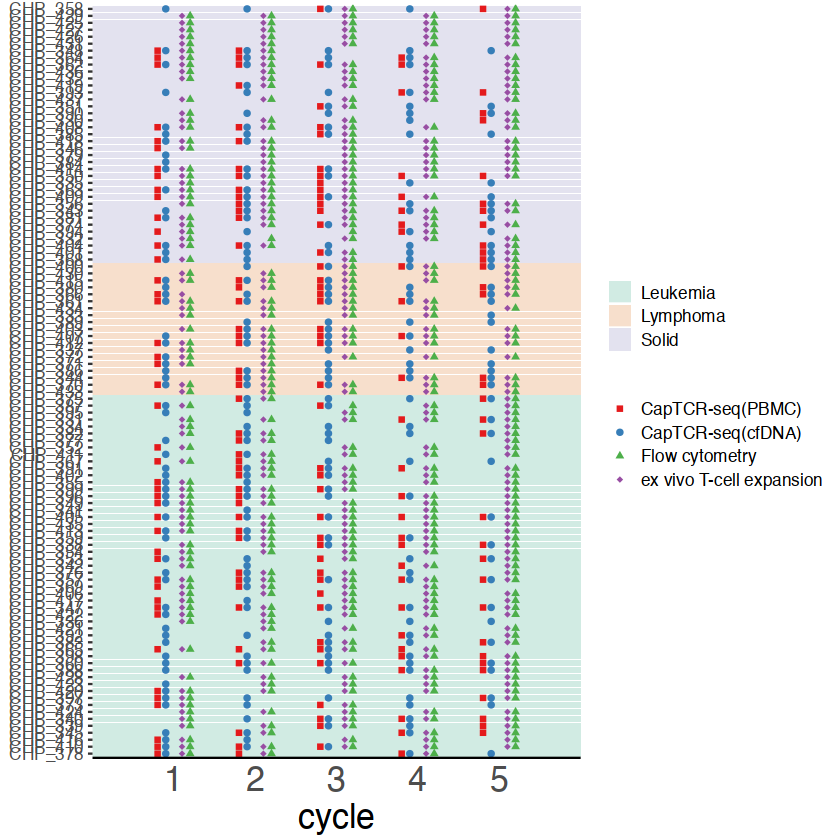

In [42]:
p0

age barplot on the right

In [43]:
head(patients_cycles)

,Patient,cycle,cancergroup,Disease_type,Age
,<fct>,<dbl>,<chr>,<chr>,<dbl>
1,CHP_346,6,Solid,NB,1
2,CHP_347,6,Leukemia,ALL,13
3,CHP_348,6,Solid,OS,18
4,CHP_349,6,Leukemia,CML,17
5,CHP_350,6,Solid,HB,1
6,CHP_352,6,Leukemia,HR ALL,17


In [44]:
p1 <- ggplot( patients_cycles, aes(Patient, Age)) +
  geom_bar(stat="identity", aes(fill=cancergroup), width=0.8, alpha = 0.2) +
  #geom_text(aes(label=Disease_type),vjust = 0.5,hjust = -1, size = 2) +
  coord_flip() +
  scale_fill_manual(values= group_col[c("Leukemia", "Lymphoma", "Solid")]) +
  scale_color_brewer(palette = "Set1")+
  scale_shape_manual(values=c(15,16,17,18)) +
  myplot + theme(legend.position="none", plot.margin = unit(c(0.1, 0.1, 0.1, 0.2), "cm"),
  axis.text.y = element_blank(), axis.title.y = element_blank(), axis.title.x = element_text(size = 20),
  axis.line.x = element_line(colour = "black"), axis.text.x = element_text(size = 20))

In [45]:
library(cowplot)


Attaching package: 'cowplot'


The following object is masked from 'package:ggpubr':

    get_legend




In [46]:
p0 <- p0 + theme(legend.position = "none") +
scale_x_discrete(labels = patients_cycles$Disease_type[match(levels(patients_cycles$Patient), patients_cycles$Patient)]) +
labs(y = "Sample collection prior chemotherapy cycle")

In [47]:
table(patients_cycles$cancergroup)


Leukemia Lymphoma    Solid 
      52       19       37 

In [48]:
p1b <- p1 + geom_bracket(xmin = c(1, 53, 72), xmax = c(52, 71, 108), y.position = c(22, 22,22),
  label.size = 7, label = c("", "", ""), coord.flip = T) + # changes the orientaitons of labels, set without label, then add with annotate
  scale_y_continuous(expand = c(0,0), limits = c(0,35), breaks = c(5,10,15,20)) +
  annotate("text", x = c(26, 61, 90), y = c(22.5, 22.5,22.3), label = c("Leukemia", "Lymphoma", "Solid tumors"), size = 7, hjust = 0) + labs(y = "Age (Years)")

In [49]:
allp <- plot_grid(p0 , p1,
ncol = 2, rel_widths = c(1, 0.3))

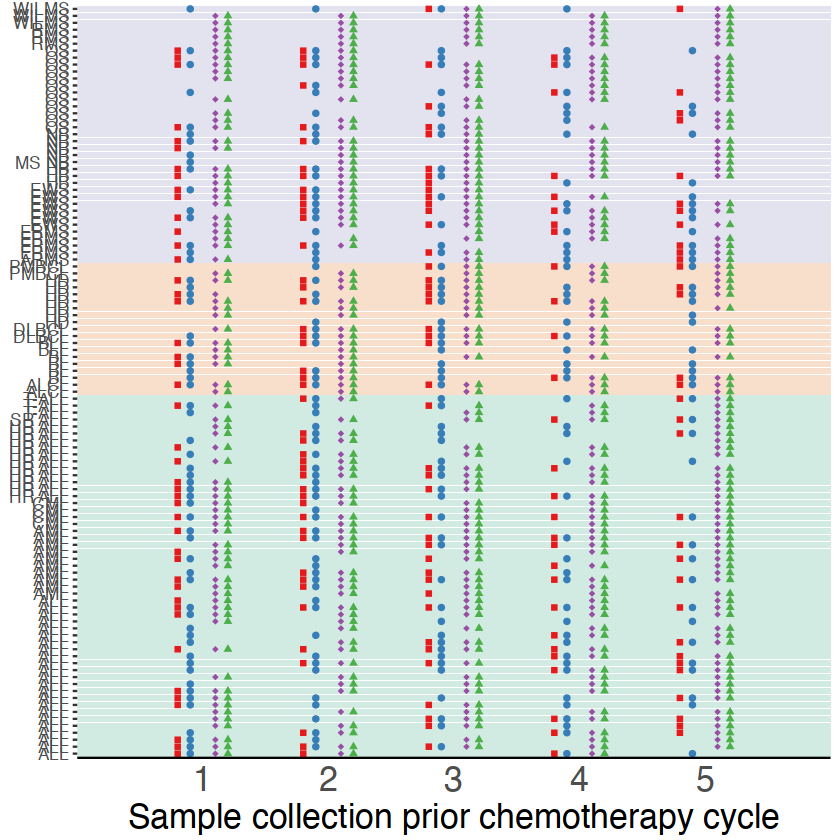

In [50]:
p0

In [51]:
pdf(paste0(plotpath,"swimmerplot.pdf"), width=10, height=16)
allp #+  theme(aspect.ratio = 4/2)
dev.off()

pdf 
  2

In [52]:
pdf(paste0(plotpath,"swimmerplot_lgd.pdf"), width=5, height=5)

grid::grid.draw( get_legend(p0 + 
theme(legend.position = 'right', legend.box = 'vertical', legend.margin = margin(0,0,0,0)) +
guides(colour = guide_legend(override.aes = list(size=3)))) )

dev.off()

pdf 
  2

## Add clinical heatmap

In [53]:
clinical <- xlsx::read.xlsx(paste0(manifestpath, "Toronto expansion and NCR data 4 back up_Lauren_halfcompleted.xlsx"), sheetIndex = 2)

In [54]:
# after cases 320
clinical <- clinical[ clinical$Study >= 330, ]

In [55]:
colnames(clinical)

[1] "Study."                   "Age.at.Dx."              
[3] "Dx."                      "Outcome.as.of.March.2023"

In [56]:
clinical$Remission <- NA
clinical$Remission[ grepl("CR", clinical$Outcome.as.of.March.2023, ignore.case = FALSE) ] <- 1
clinical$Remission[ grepl("Remission", clinical$Outcome.as.of.March.2023, ignore.case = TRUE) ] <- 1

In [57]:
clinical$Relapse <- NA
clinical$Relapse[ grepl("relapse", clinical$Outcome.as.of.March.2023, ignore.case = TRUE) ] <- 1

In [58]:
clinical$Transplant <- NA
clinical$Transplant[ grepl("transplant", clinical$Outcome.as.of.March.2023, ignore.case = TRUE) ] <- 1
clinical$Transplant[ grepl("SCT", clinical$Outcome.as.of.March.2023, ignore.case = TRUE) ] <- 1
clinical$Transplant[ grepl("BMT", clinical$Outcome.as.of.March.2023, ignore.case = TRUE) ] <- 1

In [59]:
clinical$CART <- NA
clinical$CART[ grepl("Kymriah", clinical$Outcome.as.of.March.2023, ignore.case = TRUE) ] <- 1
clinical$CART[ grepl("CTL019", clinical$Outcome.as.of.March.2023, ignore.case = TRUE) ] <- 1
clinical$CART[ grepl("CTL119", clinical$Outcome.as.of.March.2023, ignore.case = TRUE) ] <- 1 #typo?

In [60]:
clinical$Patient <- paste0("CHP_", clinical$Study)

In [61]:
clinical$Patient <- factor(clinical$Patient, levels = levels(patients_cycles$Patient) )# match order of patients

In [62]:
clinical_melt <- reshape2::melt(clinical[, c("Patient", "Relapse", "Remission", "Transplant", "CART")], id.vars = "Patient")

In [63]:
clinical_melt[ is.na(clinical_melt$value), "value" ] <- 0

In [64]:
clinical_melt$value <- as.numeric(clinical_melt$value)

In [65]:
gg_hm <- ggplot(data = clinical_melt, aes(x = variable, y = Patient, fill = value)) + 
  geom_tile() + myplot + myaxis + 
  theme(legend.position = "none", axis.title = element_blank(), axis.text.y = element_blank(), axis.ticks = element_blank(),
  plot.margin = unit(c(0.1, 0.2, 1, 1), "cm"),
  panel.border = element_rect(color = "black", fill = NA, size = 0.5)) + 
  scale_fill_gradient(low = "white", high = "black")

Warning message:
"The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."


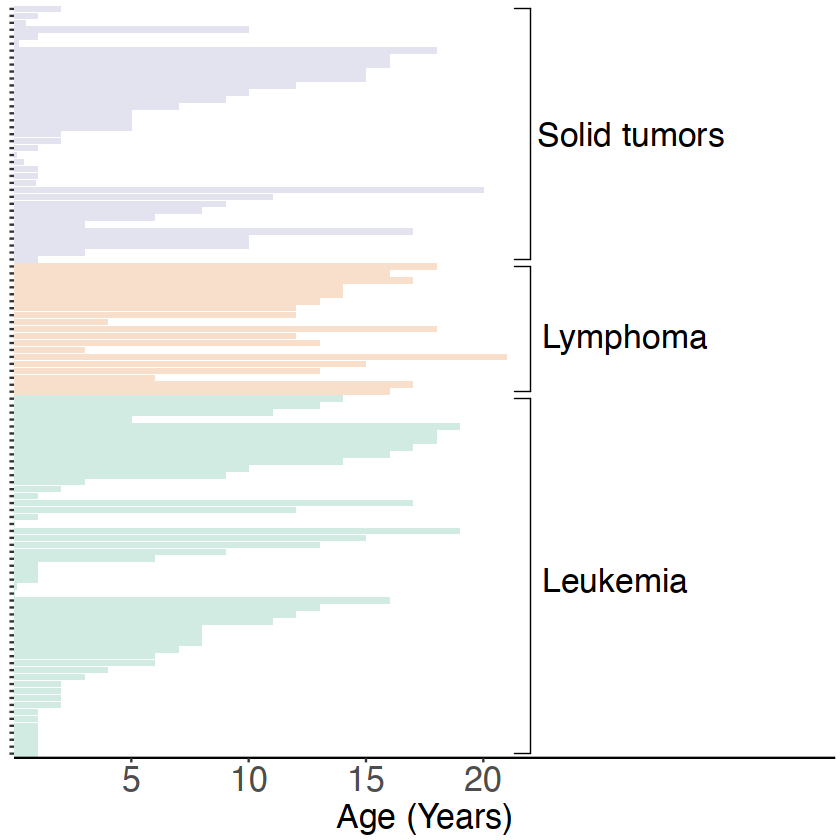

In [66]:
p1b

In [67]:
pdf(paste0(plotpath,"swimmerplot_clinical.pdf"), width=12, height=14)
plot_grid(gg_hm, p0,p1b, ncol = 3, align = "h", rel_widths = c(0.8, 3, 1.5)) 
dev.off()


pdf 
  2

Descriptives for main text

In [68]:
# remove ffpe samples
tmp <- meta_div[ !meta_div$sampletype %in% "Tumor",]
# remove normals and lfs
tmp <- tmp[ which(tmp$cancergroup != "Normal"),]
tmp <- tmp[ which(tmp$cancergroup != "LFS"),]

In [69]:
length(table(tmp$Patient))
table(tmp$sampletype, useNA = "always")

[1] 108


 PBMC cfDNA  <NA> 
  406   267     0 

In [70]:
myfreq <- as.data.frame(table(tmp$cancergroup, tmp$Patient) , stringsAsFactors = F) 
myfreq <- myfreq[ which(myfreq$Freq != 0),]

In [71]:
head(myfreq)

,Var1,Var2,Freq
,<chr>,<chr>,<int>
3,Solid,CHP_330,5
4,Leukemia,CHP_331,6
9,Solid,CHP_332,5
11,Lymphoma,CHP_333,5
13,Leukemia,CHP_334,5
18,Solid,CHP_335,5


In [72]:
dim(myfreq)

[1] 108   3

In [73]:
table(myfreq$Var1)


Leukemia Lymphoma    Solid 
      52       19       37 

In [74]:
myfreq <- as.data.frame(table(tmp$Disease_type, tmp$Patient) , stringsAsFactors = F) 
myfreq <- myfreq[ which(myfreq$Freq != 0),]

In [75]:
table(myfreq$Var1)


  ALCL    ALL    AML   ARMS     BL    BLL    CML  DLBCL   ERMS    EWS     HB 
     2     23     10      1      4      2      4      2      4      6      3 
    HD HR ALL  MS NB     NB     OS  PMBCL    RMS SR ALL  T-ALL  WILMS 
     7     11      1      4     12      2      3      1      3      3 

In [76]:
rm(tmp)

In [77]:
# remove ffpe samples
# column sampletype includes NA (they are flow data without TCR), if using which ==, it will remove all NA
tmp <- meta_div[ !meta_div$sampletype %in% "Tumor",]
# remove normals and lfs
tmp <- tmp[ which(tmp$cancergroup != "Normal"),]
tmp <- tmp[ which(tmp$cancergroup != "LFS"),]

#tmp <- tmp[ which(tmp$sampletype == "PBMC"),]

myfreq <- as.data.frame(table(tmp$cancergroup[!is.na(tmp$CD3)], tmp$Patient[!is.na(tmp$CD3)]) , stringsAsFactors = F) 
myfreq <- myfreq[ which(myfreq$Freq != 0),]

In [78]:
dim(myfreq)

[1] 108   3

In [79]:
table(myfreq$Var1)


Leukemia Lymphoma    Solid 
      52       19       37 

In [80]:
tmp <- meta_div[ which(meta_div$sampletype == "PBMC"),]

In [81]:
length(unique(tmp$Patient[ !is.na(tmp$CD3) ]))

[1] 107

In [82]:
dim(tmp[ !is.na(tmp$FOLD), ])

[1] 403  58

In [83]:
tmp <- meta_div[ which(meta_div$sampletype == "Tumor"),]

In [84]:
table(tmp$Disease_type)


 ALCL    BL   BLL DLBCL  ERMS    HD    NB    OS PMBCL 
    1     2     1     1     4     4     1     3     1 

In [85]:
table(meta_div$sampletype[!is.na(meta_div$TRB)])


 PBMC Tumor cfDNA 
  215    17   259 

In [86]:
226 + 266 

[1] 492